<a href="https://colab.research.google.com/github/AnDDoanf/LLM-repo/blob/master/neighborhood_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

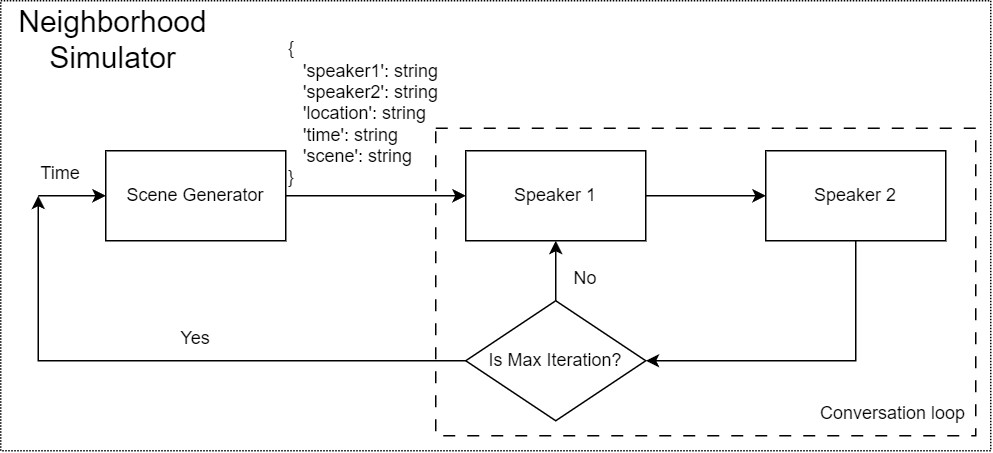

# I. Construction

In [1]:
#@title Class BuildLLM
%%capture
!pip install langchain langchain_community bitsandbytes accelerate
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain.llms import HuggingFacePipeline
from langchain_core.runnables import RunnableSequence
from torch import cuda, bfloat16
import transformers
from google.colab import userdata

class LLMConfig:
  def __init__(self):
    self.model_id = 'meta-llama/Llama-2-13b-chat-hf'
    self.device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
    self.hf_auth = userdata.get('HF_TOKEN')
    self.task = 'text-generation'
    self.temperature = 1
    self.max_new_tokens = 512
    self.repetition_penalty = 1.2

class BuildLLM:
  def __init__(self) -> None:
    self.config = LLMConfig()
    model_id = self.config.model_id
    device = self.config.device
    hf_auth = self.config.hf_auth

    bnb_config = transformers.BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=bfloat16
    )

    model_config = transformers.AutoConfig.from_pretrained(
        model_id,
        use_auth_token=hf_auth
    )

    model = transformers.AutoModelForCausalLM.from_pretrained(
        model_id,
        trust_remote_code=True,
        config=model_config,
        quantization_config=bnb_config,
        device_map='auto',
        use_auth_token=hf_auth
    )

    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_id,
        use_auth_token=hf_auth
    )

    generate_text = transformers.pipeline(
        model=model,
        tokenizer=tokenizer,
        return_full_text=True,
        task=self.config.task,
        temperature=self.config.temperature,
        max_new_tokens=self.config.max_new_tokens,
        repetition_penalty=self.config.repetition_penalty
    )

    self.llm = HuggingFacePipeline(pipeline=generate_text)
  def get_llm(self):
    return self.llm

  def get_chain(self, prompt):
    return RunnableSequence(prompt | self.llm)

# build_llm = BuildLLM()
# llm = build_llm.get_llm()

In [2]:
#@title Class UltimateRAG
%%capture

import requests
from bs4 import BeautifulSoup
url = "https://edersoncorbari.github.io/friends-scripts/"
url_paths = []
res = requests.get(url).content
soup = BeautifulSoup(res, 'html.parser')
for path in soup.find_all('a', href=True):
  url_paths.append(url+path['href'])

!pip install langchain html2text sentence-transformers faiss-gpu langchain-community playwright langchain-huggingface pypdf
!playwright install

from typing import List
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders import AsyncChromiumLoader
from langchain.document_transformers import Html2TextTransformer
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.schema import Document
import nest_asyncio
import os

nest_asyncio.apply()

class UltimateRAG:
  def __init__(self, chunk_size, chunk_overlap) -> None:
    self.chunk_size = chunk_size
    self.chunk_overlap = chunk_overlap
    self.text_splitter = CharacterTextSplitter(
        separator="\n",
        chunk_size = chunk_size,
        chunk_overlap = chunk_overlap,
        length_function=len,
        is_separator_regex= False)

  def url_text_loader(self, url_paths):
    if url_paths == []: return []
    loader = AsyncChromiumLoader(url_paths)
    docs = loader.load()
    html2text = Html2TextTransformer()
    documents = html2text.transform_documents(docs)
    chunked_documents = self.text_splitter.split_documents(documents)
    # print(f"DEBUG:", chunked_documents[0])
    return chunked_documents

  def txt_text_loader(self, dir_path):
    if dir_path == "": return []
    documents = []
    for file in os.listdir(dir_path):
        if file.endswith(".txt"):
            filepath = os.path.join(dir_path, file)
            with open(filepath, 'r') as f:
                documents.append(Document(page_content=f.read()))

    chunked_documents = self.text_splitter.split_documents(documents)
    # print(f"DEBUG:", chunked_documents[0])
    return chunked_documents

  def pdf_text_loader(self, dir_path):
    if dir_path == "": return []
    documents = []
    for file in os.listdir(dir_path):
      if file.endswith(".pdf"):
        filepath = os.path.join(dir_path, file)
        loader = PyPDFLoader(filepath)
        documents += loader.load()
    chunked_documents = self.text_splitter.split_documents(documents)
    # print(f"DEBUG:", chunked_documents[0])
    return chunked_documents

  def create_retriever(self, url_paths=[], dir_path=""):
    documents_from_url = self.url_text_loader(url_paths)
    documents_from_txt = self.txt_text_loader(dir_path)
    documents_from_pdf = self.pdf_text_loader(dir_path)
    chunked_documents = documents_from_txt + documents_from_pdf + documents_from_url

    db = FAISS.from_documents(
        chunked_documents,
        HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2'))

    self.retriever = db.as_retriever(
        search_type="similarity",
        search_kwargs={'k': 4}
    )
    return self.retriever


In [3]:
#@title Custom Output Parsers
from langchain.schema import AgentAction, AgentFinish
from langchain.chains.router.llm_router import RouterOutputParser
from langchain_core.output_parsers.base import BaseLLMOutputParser
import json

class CustomLLMOutputParser(BaseLLMOutputParser):
    def parse_result(self, result: list) -> str:
        text = result[0].text
        text = text[text.rfind('{'):]
        cleaned_text = text[:text.find('}')].strip() + "\n}"
        cleaned_text = cleaned_text.replace("'", '"')
        print("DEBUG: ", cleaned_text)
        jsonout = json.loads(cleaned_text.strip())
        return jsonout


class CustomLLMOutputParser2(BaseLLMOutputParser):
    def parse_result(self, result: list) -> str:
        text = result[0].text
        cleaned_text = text[text.rfind('[/INST]')+7:]
        return cleaned_text.strip()


In [4]:
#@title PromptGallery
class PromptGallery():
  def __init__(self) -> None:
    self.B_INST, self.E_INST = "[INST]", "[/INST]"
    word_limit = 50

    conversation_prompt = f"""
    This is the context to improve your conversation:
    {{context}}

    You will speak in the style of {{speakee}}, and exaggerate your personality.
    Speak in the first person from the perspective of {{speakee}}.
    For describing your own body movements, wrap your description in '*'.
    You should refrain from changing roles!
    Speak only from the perspective of {{speakee}}.
    Please speak in {word_limit} words or less.
    Speak directly to your neighbor, {{speaker}}.
    You should refrain from saying the same things as in previous conversation.
    DO NOT add anything else.

    It's {{time}} and you are at {{location}} speaking to your neighbor: {{speaker}}.
    This is the scene description: {{scene}}
    This is the last conversation: {{input}}

    Please {{isend}} the conversation in the style of {{speakee}}.
    """

    neighbor1_description = "John Miller, male, 50 years old. He is Emily husband. He is a high school science teacher."
    neighbor2_description = "Emily Miller, female, 45 years old. She is warm and kind. She is John Miller's wife and a work from home graphic designer."
    neighbor3_description = "Sam Thompson, male, 30 years old. He is a mechanical enginear."
    neighbor4_description = "Lisa Rodriguez, female, 32 years old. She is a warm and sociable neighbor. She is a nurse and cat-person."
    neighbor5_description = "Mark Evans, male, 27 years old. He is a friendly and approachable neighbor. He is a chef and has a wife names Rachel."

    neighborhood_prompt = f"""
    Your neighborhood has these people, their descriptions are:
    {neighbor1_description}
    {neighbor2_description}
    {neighbor3_description}
    {neighbor4_description}
    {neighbor5_description}
    """

    neighbor1_template = self.B_INST + neighborhood_prompt + f"""
    You are John Miller, 50 years old, a not very friendly neighbor known for your whiny and grumpy attitude.
    You are a dedicated high school teacher who enjoys inspiring young minds and have been teaching science for over a decade.
    Financially stable, you manage your household prudently, ensuring a comfortable yet modest lifestyle.
    Happily married to your college sweetheart, Emily, you have two children and a golden retriever named Max.
    You are often seen tending your garden or hosting barbecues.
    """ + conversation_prompt + self.E_INST


    neighbor2_template = self.B_INST + neighborhood_prompt + f"""
    You are Emily Miller, 45 years old, the friendly neighbor known for your genuine warmth and kindness. As a successful graphic designer, you work from home, balancing your creative projects with your family life seamlessly.
    Financially savvy, you contribute significantly to the household, ensuring a comfortable and secure lifestyle.
    Happily married to your college sweetheart, John, you share a deep bond and have two children and a golden retriever named Max.
    You are often seen organizing neighborhood events, baking treats for local gatherings, or volunteering at the community center, always bringing a touch of creativity and cheer to everything you do.
    """ + conversation_prompt + self.E_INST


    neighbor3_template = self.B_INST + neighborhood_prompt + f"""
    You are Sam Thompson, 30 years old, a friendly neighbor with a knack for fixing things and a love for the outdoors.
    As a mechanical engineer, you work for a reputable firm and are known for your problem-solving skills.
    Financially comfortable, you’ve invested wisely and enjoy a stable lifestyle.
    Single and content, you fill your free time with hobbies like hiking, biking, and woodworking.
    Your garage is a treasure trove of tools, and you’re always ready to help neighbors with repairs or DIY projects.
    Your approachable nature and willingness to lend a hand make you a beloved figure in the community.
    """ + conversation_prompt + self.E_INST


    neighbor4_template = self.B_INST + neighborhood_prompt + f"""
    You are Lisa Rodriguez, 32 years old, a warm and sociable neighbor who brings joy to everyone you meet.
    Working as a nurse at the local hospital, you’re dedicated to caring for others both professionally and personally.
    Financially stable, you manage your resources well, allowing for a comfortable lifestyle.
    Married to your partner, Carlos, you both enjoy a peaceful home life with your three cats.
    You’re often seen walking around the neighborhood, chatting with neighbors, and organizing community health workshops.
    Your caring nature and positive attitude make you a cornerstone of the neighborhood.

    """ + conversation_prompt + self.E_INST


    neighbor5_template = self.B_INST + neighborhood_prompt + f"""
    You are Mark Evans, 27 years old, a friendly and approachable neighbor with a passion for cooking and community service.
    As a chef at a popular local restaurant, you delight in creating delicious meals and sharing your culinary skills.
    Financially sound, you’ve built a comfortable life through hard work and dedication.
    Married to your high school sweetheart, Rachel, you have one child and a friendly labrador named Bella.
    You frequently host cookouts and potluck dinners, fostering a sense of togetherness among neighbors.
    Your generosity and culinary talent make you a cherished member of the community.
    """ + conversation_prompt + self.E_INST


    self.prompt_infos = [
        {
            'name': 'Emily Miller',
            'description': neighbor2_description,
            'prompt_template': neighbor2_template,
        },
        {
            'name': 'John Miller',
            'description': neighbor1_description,
            'prompt_template': neighbor1_template,
        },
        {
            'name': 'Sam Thompson',
            'description': neighbor3_description,
            'prompt_template': neighbor3_template,
        },
        {
            'name': 'Lisa Rodriguez',
            'description': neighbor4_description,
            'prompt_template': neighbor4_template,
        },
        {
            'name': 'Mark Evans',
            'description': neighbor5_description,
            'prompt_template': neighbor5_template,
        },
    ]

  def get_prompt_infos(self):
      return self.prompt_infos

  def get_scene_prompt(self):
    random.shuffle(self.prompt_infos)
    scene_gen_prompt = self.B_INST + f"""
    You are a creative story teller.
    You are given the time of day your goal is to give a creative scene.

    Here is some context that can help you: {{context}}

    Please choose randomly 2 person among these people: {", ".join([p['name'] for p in self.prompt_infos])}.

    Their descriptions are:
    {", ".join([p['description'] for p in self.prompt_infos])}.
    Please also give a creative scene where they are interacting and the content which they are interacting.

    Here is the previous scene:
    {{prev_scene}}

    << FORMATTING >>
    Return only a markdown code snippet with a JSON object formatted to look like:

    ```json
    {{{{
        'speaker1': string / name of the fisrt random speaker
        'speaker2': string / name of the second random speaker
        'location': string / the situation where the 2 random speakers interact
        'time': string / the input time below
        'scene': string / the content of the conversation
    }}}}
    ```
    DO NOT add anything else.
    REMEMBER:
    'speaker1' and 'speaker2' MUST be chosen randomly from the names specified above and MUST NOT be the same.
    'scene' and 'location' MUST be creative and logical based on time and are different than the previous scene. 'content' can be based on the speakers's descriptions.

    This is the input: {{input}}
    """ + self.E_INST
    return scene_gen_prompt

In [5]:
#@title Class NeighborhoodSimulator
import random
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_core.prompts.chat import ChatPromptTemplate
import gc
import torch

class NeighborhoodSimulator:
  def __init__(self) -> None:
    self.prompt_gallery = PromptGallery()

    print("Downloading Model...")
    self.create_llm()
    print("--> Model downloaded!")

    print("Creating Retriever...")
    self.create_retriever()
    print("--> Retriever created!")

    print("Creating Virtual People...")
    self.create_destination_chains()
    print("--> Virtual People created!")

  def create_llm(self):
    build_llm = BuildLLM()
    self.llm = build_llm.get_llm()

  def create_retriever(self):
    self.ultimate_rag = UltimateRAG(chunk_size=1000, chunk_overlap=200)
    self.retriever = self.ultimate_rag.create_retriever(url_paths=url_paths[:100], dir_path="/content/data")

  def create_destination_chains(self):
    self.destination_chains = {}
    prompt_infos = self.prompt_gallery.get_prompt_infos()
    for p_info in prompt_infos:
      name = p_info["name"]
      prompt_template = p_info["prompt_template"]
      prompt = ChatPromptTemplate.from_template(template=prompt_template)
      chain = LLMChain(llm=self.llm, prompt=prompt, output_parser=CustomLLMOutputParser2())
      self.destination_chains[name] = chain

  def run(self,  max_iteration = 2, max_conversation = 2):
    self.prev_scene = []
    print(">>>>>>>>Starting Simulation<<<<<<<<")
    count_iteration = 0
    for i in range (max_iteration):
        gc.collect()
        torch.cuda.empty_cache()
        time = input("What time is it? - ")
        scene_prompt = self.prompt_gallery.get_scene_prompt()
        scene_prompt_template = PromptTemplate(
            input_variables=["input"],
            template=scene_prompt
        )
        scene_gen = LLMChain(llm=self.llm, prompt=scene_prompt_template, output_parser=CustomLLMOutputParser())
        scene = scene_gen.invoke({'input':time, 'prev_scene':self.prev_scene, 'context':self.retriever})['text']
        print(f"This is the conversation between {scene['speaker1']} and {scene['speaker2']}. It's {scene['time']} at {scene['location']}. {scene['scene']}", end="\n\n")

        d = scene
        d['input'] = []
        d['context'] = self.retriever
        d['isend'] = "continue"
        for i in range (max_conversation):
          d['speakee'] = d['speaker1']
          d['speaker'] = d['speaker2']
          res = self.destination_chains[d['speaker1']].invoke(d)['text']
          if i == 0:
            d['input'] = [{f'{d["speakee"]}':res}]
          else:
            d['input'].append({f'{d["speakee"]}':res})
            d['isend'] = "end"
          gc.collect()
          torch.cuda.empty_cache()
          print(f"({d['speakee']}): {res}", end="\n\n")

          d['speaker'] = d['speaker1']
          d['speakee'] = d['speaker2']
          res = self.destination_chains[d['speaker2']].invoke(d)['text']
          d['input'].append({f'{d["speakee"]}':res})

          gc.collect()
          torch.cuda.empty_cache()
          print(f"({d['speakee']}): {res}", end="\n\n")

        if count_iteration == 5:
          count_iteration = 0
          self.prev_scene = [scene]
        else:
          count_iteration += 1
          self.prev_scene.append(scene)

# II. Inteference

In [6]:
import warnings
warnings.filterwarnings('ignore')
simulator = NeighborhoodSimulator()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

--> Model downloaded!
Creating Retriever...


--> Retriever created!
Creating Virtual People...
--> Virtual People created!


In [7]:
simulator.run()

>>>>>>>>Starting Simulation<<<<<<<<
What time is it? - 10:00 AM
DEBUG:  {
    "speaker1": "Lisa Rodriguez",
    "speaker2": "John Miller",
    "location": "the local park",
    "time": "10:00 AM",
    "scene": "As Lisa strolled through the park with her furry companion, Fluffy, she noticed John sitting on a bench, enjoying the peaceful morning. She approached him with a warm smile, holding out her hand for Fluffy to sniff."
}
This is the conversation between Lisa Rodriguez and John Miller. It's 10:00 AM at the local park. As Lisa strolled through the park with her furry companion, Fluffy, she noticed John sitting on a bench, enjoying the peaceful morning. She approached him with a warm smile, holding out her hand for Fluffy to sniff.

(Lisa Rodriguez): Hey there, John! *giggle* I just love this time of day, don't you? The sun is shining, birds are singing, and the world is just full of positivity! *bounce bounce* Oh my gosh, look how adorbs Fluffy looks today! *coo* Did you know that I

KeyboardInterrupt: Interrupted by user